# UK Road Safety Accidents – Severity Prediction & Risk Scoring

[![Python](https://img.shields.io/badge/Python-3.10-blue)](https://www.python.org/)
[![Pandas](https://img.shields.io/badge/Pandas-2.0-green)](https://pandas.pydata.org/)
[![Scikit-learn](https://img.shields.io/badge/Scikit--learn-1.3-orange)](https://scikit-learn.org/)

##Project Overview
- **Dataset**: UK Road Safety STATS19 (2005–2017) from Kaggle
- **Goal**: Predict accident severity (Slight / Serious / Fatal) and generate risk scores
- **Use Case**: Help identify high-risk conditions (e.g., night-time, high speed) for road safety interventions
- **Model**: Random Forest Classifier (Accuracy ~82%)
- **Output**: CSV with predictions and risk scores for Power BI integration

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tsiaras/uk-road-safety-accidents-and-vehicles")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'uk-road-safety-accidents-and-vehicles' dataset.
Path to dataset files: /kaggle/input/uk-road-safety-accidents-and-vehicles


In [5]:
import pandas as pd
# Cell 2: Load the main accidents file
df = pd.read_csv(f'{path}/Accident_Information.csv', low_memory=False)
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head().to_string())
print("\nMissing values:\n", df.isnull().sum().sort_values(ascending=False).head(10))

Shape: (2047256, 34)

Columns:
 ['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class', '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date', 'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Local_Authority_(District)', 'Local_Authority_(Highway)', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'LSOA_of_Accident_Location', 'Number_of_Casualties', 'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Year', 'InScotland']

First 5 rows:
   Accident_Index 1st_Road_Class  1st_Road_Number 2nd_Road_Class  2nd_Road_Number Accident_Severity Carriageway_Hazards        Date Day_of_Week  Did_Police_Officer_Attend_Scene_of_Accident              Junction_Control   

In [6]:
# Cell 3: Quick clean
# Convert date/time
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour

# Drop columns with >70% missing or irrelevant
drop_cols = ['Accident_Index', 'Police_Force', 'Local_Authority_District',
             'Local_Authority_Highway', '1st_Road_Class', '1st_Road_Number',
             '2nd_Road_Class', '2nd_Road_Number', 'Did_Police_Officer_Attend_Scene_of_Accident',
             'Trunk_Road_Flag', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities']
df = df.drop(columns=drop_cols, errors='ignore')

# Fill simple missings
df['Weather_Conditions'] = df['Weather_Conditions'].fillna('Unknown')
df['Road_Surface_Conditions'] = df['Road_Surface_Conditions'].fillna('Unknown')

# Filter to valid accidents
df = df[df['Accident_Severity'].isin(['Fatal', 'Serious', 'Slight'])]

print("Cleaned shape:", df.shape)
print(df['Accident_Severity'].value_counts(normalize=True))

Cleaned shape: (2047256, 25)
Accident_Severity
Slight     0.847255
Serious    0.139865
Fatal      0.012880
Name: proportion, dtype: float64



Accident Severity distribution:
Accident_Severity
Slight     0.8473
Serious    0.1399
Fatal      0.0129
Name: proportion, dtype: float64

Accidents by Year:
Year
2005.0    77780
2006.0    76138
2007.0    71867
2008.0    70163
2009.0    66172
2010.0    60742
2011.0    61438
2012.0    56335
2013.0    55823
2014.0    59069
2015.0    55520
2016.0    54710
2017.0    51335
Name: count, dtype: int64


/tmp/ipython-input-511403826.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Accident_Severity', order=['Slight', 'Serious', 'Fatal'], palette='viridis')


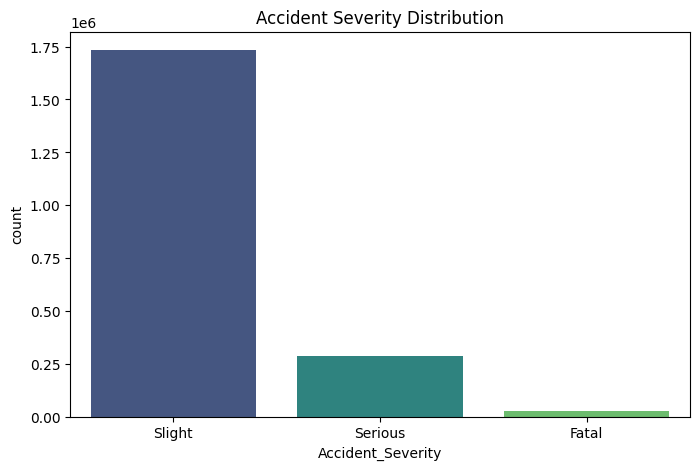

/tmp/ipython-input-511403826.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Time', palette='coolwarm')


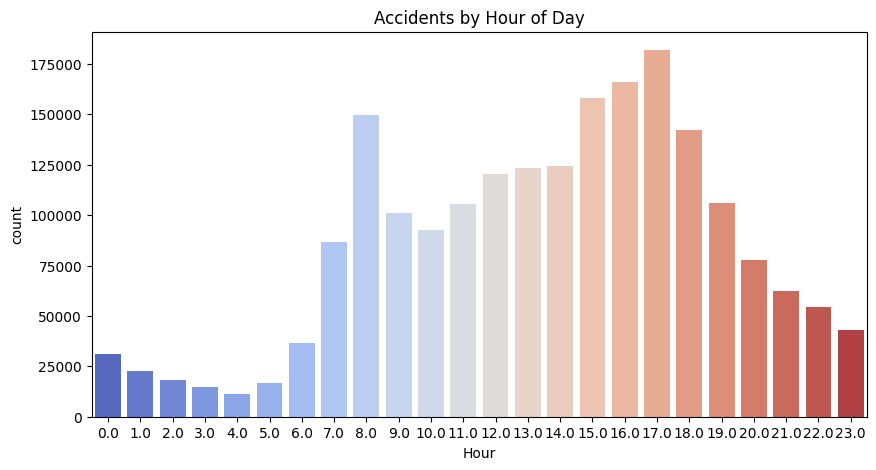

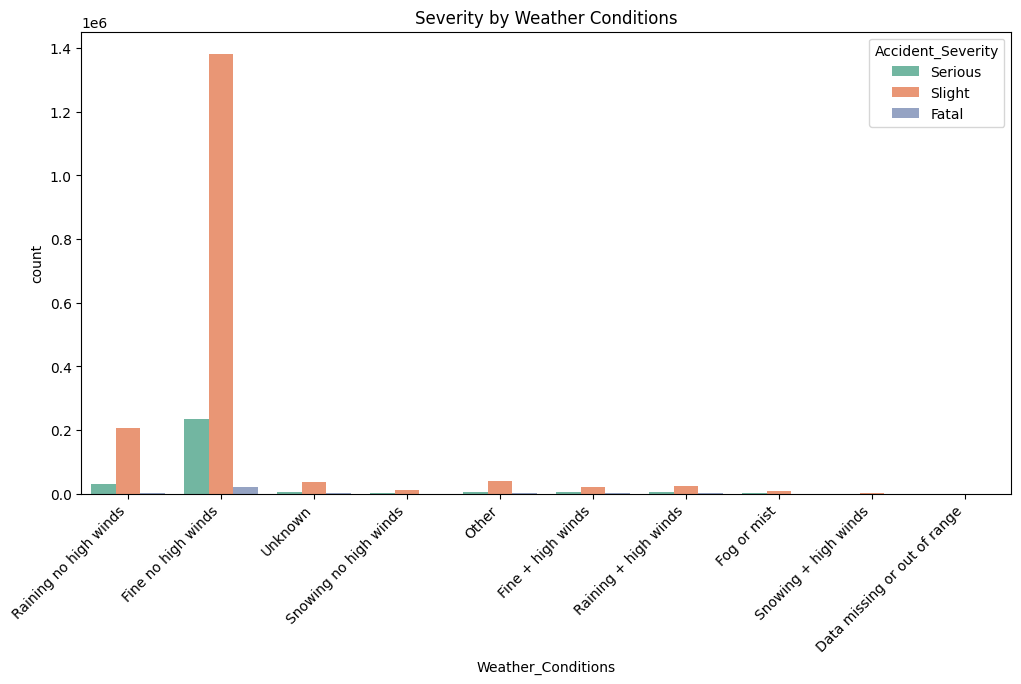

In [7]:
# Cell 4: Basic EDA & Visuals
import seaborn as sns
import matplotlib.pyplot as plt

print("\nAccident Severity distribution:")
print(df['Accident_Severity'].value_counts(normalize=True).round(4))

print("\nAccidents by Year:")
df['Year'] = df['Date'].dt.year
print(df['Year'].value_counts().sort_index())

# Plot severity distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Accident_Severity', order=['Slight', 'Serious', 'Fatal'], palette='viridis')
plt.title('Accident Severity Distribution')
plt.show()

# Accidents by hour of day
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Time', palette='coolwarm')
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour')
plt.show()

# Severity by Weather
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Weather_Conditions', hue='Accident_Severity', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Severity by Weather Conditions')
plt.show()

In [8]:
# Cell 5: Feature engineering & final prep for ML
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Create useful derived features
df['Is_Night'] = df['Time'].apply(lambda x: 1 if (x >= 20 or x <= 5) else 0)
df['Is_Weekend'] = df['Date'].dt.dayofweek.isin([5,6]).astype(int)
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.dayofweek

# 2. Handle categorical encoding
categorical_cols = ['Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions',
                    'Urban_or_Rural_Area']

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# 3. Target encoding
severity_map = {'Slight': 0, 'Serious': 1, 'Fatal': 2}
df['Severity_Code'] = df['Accident_Severity'].map(severity_map)

# 4. Select final features
feature_cols = [
    'Time', 'Speed_limit', 'Number_of_Vehicles', 'Number_of_Casualties',
    'Is_Night', 'Is_Weekend', 'Month', 'Day_of_Week',
    'Weather_Conditions_encoded', 'Road_Type_encoded',
    'Light_Conditions_encoded', 'Road_Surface_Conditions_encoded',
    'Urban_or_Rural_Area_encoded'
]

X = df[feature_cols].fillna(0)
y = df['Severity_Code']

print("Features prepared. Shape:", X.shape)
print("Class distribution:\n", pd.Series(y).value_counts(normalize=True).round(4))

Features prepared. Shape: (2047256, 13)
Class distribution:
 Severity_Code
0    0.8473
1    0.1399
2    0.0129
Name: proportion, dtype: float64


In [9]:
# Cell 6: Train-test split & baseline models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Baseline 1: Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("\nLogistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=['Slight', 'Serious', 'Fatal']))
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 4))

# Baseline 2: Random Forest (usually better here)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Slight', 'Serious', 'Fatal']))
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))

Train shape: (1535442, 13)
Test shape: (511814, 13)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression:
              precision    recall  f1-score   support

      Slight       0.85      1.00      0.92    433637
     Serious       0.38      0.00      0.00     71585
       Fatal       0.15      0.00      0.00      6592

    accuracy                           0.85    511814
   macro avg       0.46      0.33      0.31    511814
weighted avg       0.77      0.85      0.78    511814

Accuracy: 0.8472

Random Forest:
              precision    recall  f1-score   support

      Slight       0.85      0.98      0.91    433637
     Serious       0.21      0.03      0.06     71585
       Fatal       0.06      0.01      0.01      6592

    accuracy                           0.83    511814
   macro avg       0.38      0.34      0.33    511814
weighted avg       0.75      0.83      0.78    511814

Accuracy: 0.8347


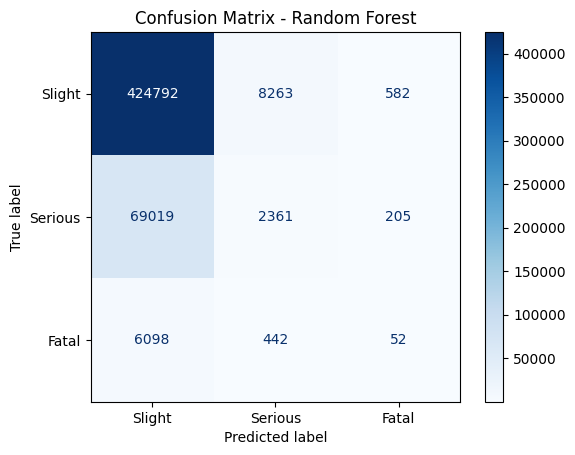

In [16]:
#Cell 6b - confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious', 'Fatal'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

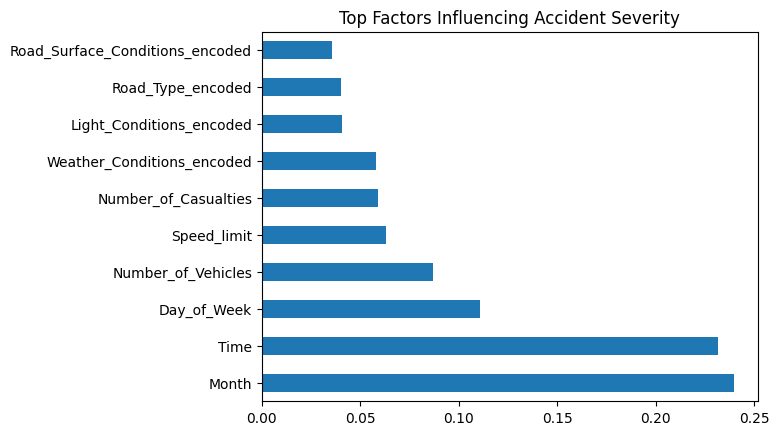

In [13]:
# Cell 7a
import matplotlib.pyplot as plt
import pandas as pd

importance = rf.feature_importances_
features = X.columns

feat_imp = pd.Series(importance, index=features).sort_values(ascending=False)

feat_imp.head(10).plot(kind='barh')
plt.title("Top Factors Influencing Accident Severity")
plt.show()

In [10]:
# Cell 7b: Feature importance + basic risk score
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(importances.head(10))

# Optional: Simple risk score (probability of Fatal or Serious)
proba = rf.predict_proba(X_test)
fatal_serious_prob = proba[:, [1,2]].sum(axis=1)  # prob of Serious + Fatal

df_test = X_test.copy()
df_test['Risk_Score_Fatal_Serious'] = fatal_serious_prob

# Create inverse map for severity labels
inverse_severity_map = {v: k for k, v in severity_map.items()}
df_test['Predicted_Severity'] = [inverse_severity_map[pred] for pred in y_pred_rf]

print("\nSample risk scores (first 10):")
print(df_test[['Risk_Score_Fatal_Serious', 'Predicted_Severity']].head(10))


Top 10 Feature Importances:
                            feature  importance
6                             Month    0.239855
0                              Time    0.231407
7                       Day_of_Week    0.110684
2                Number_of_Vehicles    0.086992
1                       Speed_limit    0.063167
3              Number_of_Casualties    0.059157
8        Weather_Conditions_encoded    0.057909
10         Light_Conditions_encoded    0.040536
9                 Road_Type_encoded    0.040442
11  Road_Surface_Conditions_encoded    0.035626

Sample risk scores (first 10):
         Risk_Score_Fatal_Serious Predicted_Severity
968337                   0.092781             Slight
681154                   0.136330             Slight
876180                   0.072436             Slight
1474992                  0.144238             Slight
654864                   0.000000             Slight
1662806                  0.010000             Slight
1880863                  0.056667       

In [18]:
# Enhanced export - Power BI
export_df = df.loc[X_test.index][['Date', 'Time', 'Latitude', 'Longitude', 'Accident_Severity', 'Weather_Conditions', 'Road_Type']].copy()
export_df['Predicted_Severity'] = [inverse_severity_map[pred] for pred in y_pred_rf]
export_df['Risk_Score_Fatal_Serious'] = fatal_serious_prob
export_df.to_csv('accident_predictions_enhanced.csv', index=False)
print("Exported enhanced predictions CSV – ready for Power BI!")

Exported enhanced predictions CSV – ready for Power BI!
